# Cost of living & Venues Data Analysis of most popular cities in Bolivia

## 1. Introduction

### 1.1. Description & Disscusion of the Background

[Bolivia](https://en.wikipedia.org/wiki/Bolivia) according to the census conducted in 2012 has a population of 10,027,254 people, and the main cities according to the [population census](http://ibce.org.bo/publicaciones-descarga.php?id=2119&opcion=5) are:

| City |  Population   | Population Density |
|------|---------------|--------------------|
|  La Paz |  2.706.351 |      20.20         |
|  Santa Cruz |  2.706.351 |      7.16      |
|  Cochabamba |  2.706.351 |      31.60     |
|  Total      |  6.191.533 |          |

Only these 3 cities represent 61.74% of the general population, that is why the analysis will focus on these 3 cities in the following points:
*   Cost of living
*   Similarities between these 3 cities from the economic point of view
*   Relationship between the venues of each city through the Foursquare API to find similarities between the different districts of the city of La Paz, Santa Cruz and Cochabamba

This analysis allows people who have an interest in Bolivia to see a comparative analysis of the cost of living in relation to different cities, growth and if they decide to move what type of zones or districts can be ideal or similar between the larger cities from the country

### 1.2 Data Description

* For the cost of living analysis, [Numbeo](https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2010&region=005) data will be taken to determine the growth of Bolivia

    For example data obtained for 2009:
	
|  Country      |   Cost of Living Index      |Rent Index |Cost of Living Plus Rent Index|Groceries Index|Restaurant Price Index|Local Purchasing Power Index|
|-----------------------|---------------|------|-----|-----|-----|-----|
|  Bolivia      |    46.72      |  21.76 |36.82|27.09|37.16|32.47|
 	 	 	 	 	 	 	

* For the analysis of the 3 cities, the detailed data of the [Numbeo website](https://www.numbeo.com/cost-of-living/in/Santa-Cruz-Bolivia) will be obtained, including the cost of basic basket items, among others, and the comparison will be established against the different capitals of South America and the data clustering will be carried out to determine a classification and similarity between the different cities.

    A sample Data for Santa Cruz City

|Description|Price|
|-----------------------|---------------|
|Meal, Inexpensive Restaurant| 	3.18  |
|Meal for 2 People| 21.18 |
|Tomato (1kg)| 	1.04 |
|Potato (1kg)| 	0.67 |

* Finally, an analysis will be made between the different districts of the city of La Paz, Cochabamba and Santa Cruz to determine which districts are similar in relation to points of interest found through the [Foursquare API](https://developer.foursquare.com/).

    A sample data from Foursquare
|District|City|Venue| Venue Category| Latitude | Longitude|
|--------|-----------------------|---------------|-----|-----|----|
|District 1|Santa Cruz | Casa del Camba | Fast food | 23.123123| 22.2312|
|District 1|Cochabamba | Llajuuita | Fast food | 23.122323| 22.987621|
|Center |La Paz | Copacabana | Fast food | 23.122323| 22.987621|

## 2. Methodology

### 2.1 Obtaining and Formating Data

#### Installing Dependences

In [3]:
! easy_install beautifulsoup4

Searching for beautifulsoup4
Best match: beautifulsoup4 4.7.1
Adding beautifulsoup4 4.7.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for beautifulsoup4
Finished processing dependencies for beautifulsoup4


In [4]:
! easy_install html5lib

Searching for html5lib
Best match: html5lib 1.0.1
Adding html5lib 1.0.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for html5lib
Finished processing dependencies for html5lib


In [5]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [6]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [5]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



#### Import Libraries

In [168]:
import pandas as pd
import requests
import numpy as np
import io
import requests
from bs4 import BeautifulSoup
import geocoder # import geocoder
from geopy.geocoders import Nominatim
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

Set and obtain the columns of the dataframe using a single request with random year

In [334]:
#Years for web scraping on Numbeo Page
years = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
#URL for web scrapping
urlCostLivingIndex = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title={}'
urlCostLivingForHeaders = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2009'
#create var for column data frame
columnNames = ['Year']
#create request only for obtain the value of headers using specific year
boliviaCostLivingRequest = requests.get(urlCostLivingForHeaders)
boliviaSoup = BeautifulSoup(boliviaCostLivingRequest.text, "html5lib")

#Create the column Names for data frame
for tag in boliviaSoup.find_all('table'):
        if (tag.get('id') == "t2"):
            for head in tag.thead.tr:
                name = head.string;
                if (name not in ['\n\t','\n\t\t']):
                    columnNames.append(name)
#Create a data frame with the table of Numbeo web page
dfBoliviaCostLiving = pd.DataFrame(columns=columnNames)
dfBoliviaCostLiving

Empty DataFrame
Columns: [Year, Rank, Country, Cost of Living Index, Rent Index, Cost of Living Plus Rent Index, Groceries Index, Restaurant Price Index, Local Purchasing Power Index]
Index: []

Fill data for every single year

In [340]:
#Obtain data for every year using the array and one request for each year
for year in years:
    boliviaCostLivingRequestPerYear = requests.get(urlCostLivingIndex.format(year))
    boliviaSoupPerYear = BeautifulSoup(boliviaCostLivingRequestPerYear.text, "html5lib")
    for tag in boliviaSoupPerYear.find_all('table'):
        if (tag.get('id') == "t2"):
            rows = tag.find_all('tr')
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                if (len(cols)!=0):
                    dfBoliviaCostLiving = dfBoliviaCostLiving.append({
                        'Year' : int(year),
                        'Rank' : cols[0],
                        'Country': cols[1],
                        'Cost of Living Index' : float(cols[2]),
                        'Rent Index' : float(cols[3]),
                        'Cost of Living Plus Rent Index' : float(cols[4]),
                        'Groceries Index' : float(cols[5]),
                        'Restaurant Price Index' : float(cols[6]),
                        'Local Purchasing Power Index' : float(cols[7]),
                    }, ignore_index=True)

Clean and drop duplicate data and reset indexes, I considerer these values on the table as important for analysis.

In [398]:
boliviaOnlyFiltered = dfBoliviaCostLiving[dfBoliviaCostLiving.Country == 'Bolivia']
#Delete duplicates and reorder data
boliviaOnlyFiltered = boliviaOnlyFiltered.drop_duplicates().reset_index(drop=True)
boliviaOnlyFiltered.drop(labels=['Rank','Cost of Living Plus Rent Index','Local Purchasing Power Index','Country'], axis=1,inplace = True)
boliviaOnlyFiltered

Year  Cost of Living Index  Rent Index  Groceries Index  \
0  2009                 46.72       21.76            27.09   
1  2010                 38.01       19.41            26.40   
2  2011                 37.41       15.21            28.32   
3  2013                 41.50       12.48            36.42   
4  2014                 40.98       13.56            36.85   
5  2015                 40.02       10.84            33.95   
6  2016                 37.44       10.02            30.58   
7  2017                 38.65       11.07            32.13   
8  2018                 36.53        9.87            28.84   
9  2019                 34.37       10.88            26.90   

   Restaurant Price Index  
0                   37.16  
1                   32.87  
2                   23.36  
3                   21.48  
4                   24.62  
5                   26.01  
6                   24.42  
7                   27.97  
8                   28.52  
9                   27.96

As we see exists some missing data on the year 2012, it'll filled with the mean

In [408]:
boliviaOnlyFiltered = boliviaOnlyFiltered.append({
                        'Year' : 2012,
                        'Cost of Living Index' : round(boliviaOnlyFiltered['Cost of Living Index'].mean(),2),
                        'Rent Index' : round(boliviaOnlyFiltered['Rent Index'].mean(),2),
                        'Groceries Index' : round(boliviaOnlyFiltered['Groceries Index'].mean(),2),
                        'Restaurant Price Index' : round(boliviaOnlyFiltered['Restaurant Price Index'].mean(),2)
                    }, ignore_index=True)
boliviaOnlyFiltered = boliviaOnlyFiltered.sort_values(['Year']).reset_index(drop=True)
boliviaOnlyFiltered

Year  Cost of Living Index  Rent Index  Groceries Index  \
0   2009                 46.72       21.76            27.09   
1   2010                 38.01       19.41            26.40   
2   2011                 37.41       15.21            28.32   
3   2012                 39.16       13.51            30.75   
4   2013                 41.50       12.48            36.42   
5   2014                 40.98       13.56            36.85   
6   2015                 40.02       10.84            33.95   
7   2016                 37.44       10.02            30.58   
8   2017                 38.65       11.07            32.13   
9   2018                 36.53        9.87            28.84   
10  2019                 34.37       10.88            26.90   

    Restaurant Price Index  
0                    37.16  
1                    32.87  
2                    23.36  
3                    27.44  
4                    21.48  
5                    24.62  
6                    26.01  
7                    24.42  
8                    27.97  
9                    28.52  
10                   27.96

#### Show Plots for every variable through years

##### Year vs Index of Cost of living

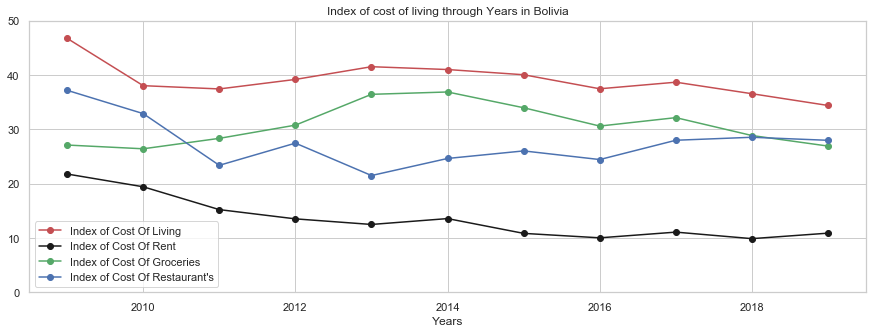

In [500]:
plt.figure(figsize=(15,5))
plt.plot('Year','Cost of Living Index','ro-', data = boliviaOnlyFiltered , label = 'Index of Cost Of Living')
plt.plot('Year','Rent Index', 'ko-', data = boliviaOnlyFiltered, label = 'Index of Cost Of Rent')
plt.plot('Year','Groceries Index', 'go-',data = boliviaOnlyFiltered, label = 'Index of Cost Of Groceries')
plt.plot('Year','Restaurant Price Index', 'bo-' ,data = boliviaOnlyFiltered, label = "Index of Cost Of Restaurant's")
plt.title('Index of cost of living through Years in Bolivia')
plt.xlabel('Years')
plt.ylim(0,50)
plt.legend()
plt.show()

#### Analisys for the most popular cities on Bolivia

Extraction of data with web scrapping from Numbeo

In [673]:
#List of cities to make the comparison in format required by Numbeo
capitals = ['La-Paz','Cochabamba','Santa-Cruz-Bolivia','Brasilia','Santiago','Bogota','Quito','Georgetown','Asuncion','Lima',
            'Paramaribo','Montevideo','Caracas','Belmopan','Guatemala-City','San-Salvador','Tegucigalpa','Managua',
            'San-Jose-Costa-Rica','Panama-City','Tirana','Berlin','Vienna','Baku','Brussels','Minsk','Sarajevo',
            'Sofia','Nicosia','Zagreb','Copenhagen','Bratislava','Madrid','Tallinn','Moscow','Helsinki','Paris',
            'Athens','Budapest','Dublin','Rome','Astana','Riga','Vilnius','Luxembourg','Skopje',
            'Chisinau','Monaco','Podgorica','Oslo','Amsterdam','Lisbon','London','Prague',
            'Belgrade','Stockholm','Kiev']
#URL for web scrapping
urlCostLivingCity = 'https://www.numbeo.com/cost-of-living/in/{}?displayCurrency=USD'
frame = []
#Iterate through all cities
for city in capitals:
    df  = ExtractDataPerCity(urlCostLivingCity.format(city),city)
    frame.append(df)

In [674]:
mergedData = pd.concat(frame, sort=False)
mergedData = mergedData.reset_index(drop=True)
mergedData

Longitude   Latitude                 City Meal, Inexpensive Restaurant  \
0  -68.133623 -16.495545               La-Paz                         3.61   
1  -66.156959 -17.393585           Cochabamba                         2.99   
2  -61.500000 -17.333333   Santa-Cruz-Bolivia                         3.18   
3  -53.200000 -10.333333             Brasilia                         7.47   
4  -70.650445 -33.437797             Santiago                         8.63   
5  -74.075848   4.598699               Bogota                         3.94   
6  -78.512327  -0.220164                Quito                            4   
7  -84.558831  38.209797           Georgetown                         5.51   
8  -57.634381 -25.280046             Asuncion                         4.17   
9  -77.036526 -12.062107                 Lima                         2.98   
10 -55.177043   5.821609           Paramaribo                         3.35   
11 -56.191357 -34.905904           Montevideo                         9.93   
12 -66.914602  10.506098              Caracas                         3.25   
13 -88.770018  17.250199             Belmopan                            5   
14 -90.518519  14.622233       Guatemala-City                         5.17   
15 -89.191425  13.698994         San-Salvador                            5   
16 -87.201263  14.093192          Tegucigalpa                            5   
17 -86.273717  12.146124              Managua                          3.6   
18 -84.079578   9.932543  San-Jose-Costa-Rica                         7.64   
19 -85.654573  30.160083          Panama-City                           10   
20  19.818532  41.327946               Tirana                         5.06   
21  13.388860  52.517037               Berlin                         8.99   
22  16.372504  48.208354               Vienna                        11.23   
23  49.832675  40.375443                 Baku                         5.87   
24   4.351697  50.846557             Brussels                        16.85   
25  27.561879  53.902334                Minsk                         7.09   
26  18.386687  43.851977             Sarajevo                         4.02   
27  23.322179  42.697863                Sofia                         6.89   
28  33.373696  35.180282              Nicosia                         14.6   
29  15.977048  45.813177               Zagreb                         7.57   
30  12.570072  55.686724           Copenhagen                        18.05   
31  17.109306  48.151699           Bratislava                         6.74   
32  -3.703582  40.416705               Madrid                        12.36   
33  24.745369  59.437216              Tallinn                         8.99   
34  37.617494  55.750446               Moscow                         9.19   
35  24.942568  60.167409             Helsinki                        13.48   
36   2.351499  48.856610                Paris                        16.85   
37 -83.376398  33.959768               Athens                        13.48   
38  19.040471  47.498382             Budapest                         6.99   
39  -6.260273  53.349764               Dublin                        16.85   
40  12.485338  41.894802                 Rome                        16.85   
41  71.430550  51.128258               Astana                         6.48   
42  24.105185  56.949398                 Riga                         7.86   
43  25.282911  54.687046              Vilnius                         8.99   
44   6.129675  49.815868           Luxembourg                         19.1   
45  21.431649  41.996092               Skopje                         6.39   
46  28.832253  47.024471             Chisinau                          5.5   
47   7.419758  43.731142               Monaco                        28.08   
48  19.262108  42.441524            Podgorica                         5.62   
49  10.738970  59.913330                 Oslo                         20.6   
50   4.897976  52.374540  

In [669]:
def ExtractDataPerCity(url,city):
    df = pd.DataFrame(columns= ['0','1'])
    request = requests.get(url)
    requestSoup = BeautifulSoup(request.text, "html5lib")
    for tag in requestSoup.find_all('table'):
        rows = tag.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            if (len(cols)!=0):
                if (cols[0] != ''):
                    if (len(cols)>2):
                        df = df.append({
                        '0':cols[0],
                        '1':float(cols[1].replace('\xa0$','').replace(',',''))
                        }, ignore_index=True)
    df = df.T
    df = df.rename(columns=df.iloc[0])
    df.drop(df.index[0],inplace=True)
    df.insert(loc=0, column='City', value=city)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    df.insert(loc=0, column='Latitude', value=latitude)
    df.insert(loc=0, column='Longitude', value=longitude)
    return df

In [686]:
# set number of clusters
kclusters = 15

capital_grouped_clustering = mergedData.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(capital_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 1, 14,  1,  6, 14,  1, 10, 14,  1,  7])

In [687]:
# add clustering labels
capital_grouped_clustering.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_)

In [688]:
capital_grouped_clustering

Cluster Labels  Longitude   Latitude Meal, Inexpensive Restaurant  \
0                1 -68.133623 -16.495545                         3.61   
1               14 -66.156959 -17.393585                         2.99   
2                1 -61.500000 -17.333333                         3.18   
3                6 -53.200000 -10.333333                         7.47   
4               14 -70.650445 -33.437797                         8.63   
5                1 -74.075848   4.598699                         3.94   
6               10 -78.512327  -0.220164                            4   
7               14 -84.558831  38.209797                         5.51   
8                1 -57.634381 -25.280046                         4.17   
9                7 -77.036526 -12.062107                         2.98   
10               4 -55.177043   5.821609                         3.35   
11              10 -56.191357 -34.905904                         9.93   
12              12 -66.914602  10.506098                         3.25   
13               3 -88.770018  17.250199                            5   
14               1 -90.518519  14.622233                         5.17   
15               1 -89.191425  13.698994                            5   
16               1 -87.201263  14.093192                            5   
17               1 -86.273717  12.146124                          3.6   
18              10 -84.079578   9.932543                         7.64   
19               6 -85.654573  30.160083                           10   
20               1  19.818532  41.327946                         5.06   
21              13  13.388860  52.517037                         8.99   
22               8  16.372504  48.208354                        11.23   
23               1  49.832675  40.375443                         5.87   
24               8   4.351697  50.846557                        16.85   
25               1  27.561879  53.902334                         7.09   
26               7  18.386687  43.851977                         4.02   
27               7  23.322179  42.697863                         6.89   
28               7  33.373696  35.180282                         14.6   
29               7  15.977048  45.813177                         7.57   
30              11  12.570072  55.686724                        18.05   
31               6  17.109306  48.151699                         6.74   
32              13  -3.703582  40.416705                        12.36   
33               6  24.745369  59.437216                         8.99   
34              13  37.617494  55.750446                         9.19   
35               5  24.942568  60.167409                        13.48   
36               9   2.351499  48.856610                        16.85   
37               7 -83.376398  33.959768                        13.48   
38               7  19.040471  47.498382                         6.99   
39               5  -6.260273  53.349764                        16.85   
40               9  12.485338  41.894802                        16.85   
41               6  71.430550  51.128258                         6.48   
42               6  24.105185  56.949398                         7.86   
43               6  25.282911  54.687046                         8.99   
44               9   6.129675  49.815868                         19.1   
45               1  21.431649  41.996092                         6.39   
46              14  28.832253  47.024471                          5.5   
47               2   7.419758  43.731142                        28.08   
48               6  19.262108  42.441524                         5.62   
49              11  10.738970  59.913330                         20.6   
50               9   4.897976  52.374540                        16.85   
51              10  -9.136592  38.707751                         9.55   
52               0  -0.127647  51.507322                        19.03   
53               6  14.421254  50.087465                      

In [689]:
# create map
map_clusters = folium.Map(zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(capital_grouped_clustering['Latitude'], capital_grouped_clustering['Longitude'], capital_grouped_clustering['Cluster Labels'], capital_grouped_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters